In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use(['seaborn-darkgrid'])
import pymc3 as pm
import numpy as np
import  pandas as pd

# Model averaging

When confronted with more than one model we have several options. One of them is to perform model selection, using for example a given Information Criterion as exemplified [in this notebook](model_comparison.ipynb) and this other [example](GLM-model-selection.ipynb). Model selection is appealing for its simplicity, but we are discarding information about the uncertainty in our models. This is somehow similar to computing the full posterior and then just keep a point-estimate like the posterior mean; we may become overconfident of what we really know.

One alternative is to perform model selection but discuss all the different models together with the computed values of a given Information Criterion. It is important to put all these numbers and tests in the context of our problem so that we and our audience can have a better feeling of the possible limitations and shortcomings of our methods. If you are in the academic world you can use this approach to add elements to the discussion section of a paper, presentation, thesis, and so on.

Yet another approach is to perform model averaging. The idea now is to generate a meta-model (and meta-predictions) using a weighted average of the models. There are several ways to do this and PyMC3 includes 3 of them that we are going to briefly discuss, you will find a more thorough explanation in the work by [Yuling Yao et. al.](https://arxiv.org/abs/1704.02030)

## Pseudo Bayesian model averaging

Bayesian models can be weighted by their marginal likelihood, this is known as Bayesian Model Averaging. While this is theoretically appealing, is problematic in practice: on the one hand the marginal likelihood is highly sensible to the specification of the prior, in a way that parameter estimation is not, and on the other computing the marginal likelihood is usually a challenging task. An alternative route is to use the values of WAIC (Widely Applicable Information Criterion) or LOO (pareto-smoothed importance sampling Leave-One-Out cross-validation), which we will call generically IC, to estimate weights. We can do this by using the following formula:

$$w_i = \frac {e^{ - \frac{1}{2} dIC_i }} {\sum_j^M e^{ - \frac{1}{2} dIC_j }}$$

Where $dIC_i$ is the difference between the i-esim information criterion value and the lowest one. Remember that the lowest the value of the IC, the better. We can use any information criterion we want to compute a set of weights, but, of course, we cannot mix them. 

This approach is called pseudo Bayesian model averaging, or Akaike-like weighting and is an heuristic way to compute the relative probability of each model (given a fixed set of models) from the information criteria values. Look how the denominator is just a normalization term to ensure that the weights sum up to one.

## Pseudo Bayesian model averaging with Bayesian Bootstrapping

The above formula for computing weights is a very nice and simple approach, but with one major caveat it does not take into account the uncertainty in the computation of the IC. We could compute the standard error of the IC (assuming a Gaussian approximation) and modify the above formula accordingly. Or we can do something more robust, like using a [Bayesian Bootstrapping](http://www.sumsar.net/blog/2015/04/the-non-parametric-bootstrap-as-a-bayesian-model/) to estimate, and incorporate this uncertainty.

## Stacking

The third approach implemented in PyMC3 is know as _stacking of predictive distributions_ and it has been recently [proposed](https://arxiv.org/abs/1704.02030). We want to combine several models in a metamodel in order to minimize the diverge between the meta-model and the _true_ generating model, when using a logarithmic scoring rule this is equivalently to:

$$\max_{n} \frac{1}{n} \sum_{i=1}^{n}log\sum_{k=1}^{K} w_k p(y_i|y_{-i}, M_k)$$

Where $n$ is the number of data points and $K$ the number of models. To enforce a solution we constrain $w$ to be $w_k \ge 0$ and  $\sum_{k=1}^{K} w_k = 1$. 

The quantity $p(y_i|y_{-i}, M_k)$ is the leave-one-out predictive distribution for the $M_k$ model. Computing it requires fitting each model $n$ times, each time leaving out one data point. Fortunately we can approximate the exact leave-one-out predictive distribution using LOO (or even WAIC), and that is what we do in practice.

## Weighted posterior predictive samples

Once we have computed the weights, using any of the above 3 methods,  we can use them to get a weighted posterior predictive samples. PyMC3 offers functions to perform these steps in a simple way, so let see them in action using an example.

The following example is taken from the superb book [Statistical Rethinking](http://xcelab.net/rm/statistical-rethinking/) by Richard McElreath. You will find more PyMC3 examples from this book in this [repository](https://github.com/aloctavodia/Statistical-Rethinking-with-Python-and-PyMC3). We are going to explore a simplified version of it. Check the book for the whole example and a more thorough discussion of both, the biological motivation for this problem and a theoretical/practical discussion of using Information Criteria to compare, select and average models.

Briefly, our problem is as follows: We want to explore the composition of milk across several primate species, it is hypothesized that females from species of primates with larger brains produce more _nutritious_ milk (loosely speaking this is done _in order to_ support the development of such big brains). This is an important question for evolutionary biologists and try to give and answer we will use 3 variables, two predictor variables: the proportion of neocortex compare to the total mass of the brain and the logarithm of the body mass of the mothers. And for predicted variable, the kilocalories per gram of milk. With these variables we are going to build 3 different linear models:
 
1. A model using only the neocortex variable
2. A model using only the logarithm of the mass variable
3. A model using both variables

Let start by uploading the data and centering the `neocortex` and `log mass` variables, for better sampling.

In [2]:
d = pd.read_csv('../data/milk.csv')
d.iloc[:,1:] = d.iloc[:,1:] - d.iloc[:,1:].mean()
d.head()

,kcal.per.g,neocortex,log_mass
0,0.49,-0.123706,-0.831353
1,0.47,-0.030706,0.158647
2,0.56,-0.030706,0.181647
3,0.89,0.000294,-0.579353
4,0.92,0.012294,-1.885353


Now that we have the data we are going to build our first model using only the `neocortex`.

In [3]:
with pm.Model() as model_0:
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    beta = pm.Normal('beta', mu=0, sigma=10)
    sigma = pm.HalfNormal('sigma', 10)
    
    mu = alpha + beta * d['neocortex']
    
    kcal = pm.Normal('kcal', mu=mu, sigma=sigma, observed=d['kcal.per.g'])
    trace_0 = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta, alpha]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:04<00:00, 1028.80draws/s]


The second model is exactly the same as the first one, except we now use the logarithm of the mass

In [4]:
with pm.Model() as model_1:
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    beta = pm.Normal('beta', mu=0, sigma=1)
    sigma = pm.HalfNormal('sigma', 10)
    
    mu = alpha + beta * d['log_mass']
    
    kcal = pm.Normal('kcal', mu=mu, sigma=sigma, observed=d['kcal.per.g'])
    
    trace_1 = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta, alpha]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:04<00:00, 1163.58draws/s]


And finally the third model using the `neocortex` and `log_mass` variables

In [5]:
with pm.Model() as model_2:
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    beta = pm.Normal('beta', mu=0, sigma=1, shape=2)
    sigma = pm.HalfNormal('sigma', 10)

    mu = alpha + pm.math.dot(beta, d[['neocortex','log_mass']].T)

    kcal = pm.Normal('kcal', mu=mu, sigma=sigma, observed=d['kcal.per.g'])

    trace_2 = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta, alpha]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:05<00:00, 962.26draws/s] 


Now that we have sampled the posterior for the 3 models, we are going to compare them visually. One option is to use the `forestplot` function that supports plotting more than one trace.

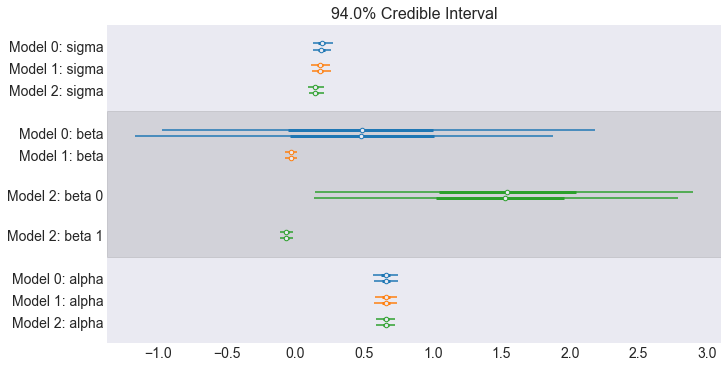

In [6]:
traces = [trace_0, trace_1, trace_2]
pm.forestplot(traces, figsize=(10, 5));

Another option is to plot several traces in a same plot is to use `densityplot`. This plot is somehow similar to a forestplot, but we get truncated KDE plots (by default 95% credible intervals) grouped by variable names together with a point estimate (by default the mean).

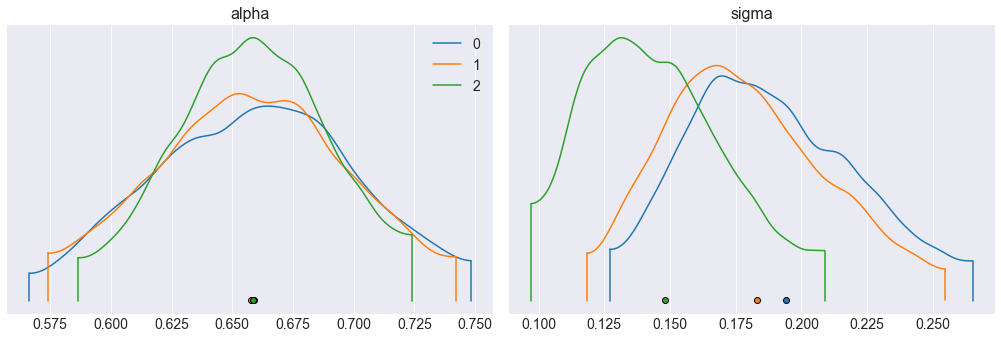

In [7]:
pm.densityplot(traces, var_names=['alpha', 'sigma']);

Now that we have sampled the posterior for the 3 models, we are going to use WAIC (Widely applicable information criterion) to compare the 3 models. We can do this using the `compare` function included with PyMC3.

In [8]:
model_dict = dict(zip([model_0, model_1, model_2], traces))
comp = pm.compare(model_dict, method='BB-pseudo-BMA')
comp

/home/junpenglao/Documents/pymc3/pymc3/stats.py:219: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
2,-15.44,2.58,0,0.89,4.76,0,1
1,-8.88,2.05,6.56,0.04,3.96,2.1,1
0,-7.13,1.94,8.31,0.07,2.95,4.13,0


We can see that the best model is `model_2`, the one with both predictor variables. Notice the DataFrame is ordered from lowest to highest WAIC (_i.e_ from _better_ to _worst_ model). Check [this notebook](model_comparison.ipynb) for a more detailed discussing on model comparison.

We can also see that we get a column with the relative `weight` for each model (according to the first equation at the beginning of this notebook). This weights can be _vaguely_ interpreted as the probability that each model will make the correct predictions on future data. Of course this interpretation is conditional on the models used to compute the weights, if we add or remove models the weights will change. And also is dependent on the assumptions behind WAIC (or any other Information Criterion used). So try to do not overinterpret these `weights`. 

Now we are going to use copmuted `weights` to generate predictions based not on a single model but on the weighted set of models. This is one way to perform model averaging. Using PyMC3 we can call the `sample_posterior_predictive_w` function as follows:

In [9]:
ppc_w = pm.sample_posterior_predictive_w(traces, 1000, [model_0, model_1, model_2],
                        weights=comp.weight.sort_index(ascending=True),
                        progressbar=False)

Notice that we are passing the weights ordered by their index. We are doing this because we pass `traces` and `models` ordered from model 0 to 2, but the computed weights are ordered from lowest to highest WAIC (or equivalently from larger to lowest weight). In summary, we must be sure that we are correctly pairing the weights and models.

We are also going to compute PPCs for the lowest-WAIC model

In [10]:
ppc_2 = pm.sample_posterior_predictive(trace_2, 1000, model_2,
                     progressbar=False)

A simple way to compare both kind of predictions is to plot their mean and hpd interval

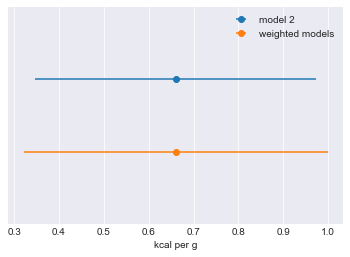

In [11]:
mean_w = ppc_w['kcal'].mean()
hpd_w = pm.hpd(ppc_w['kcal']).mean(0)

mean = ppc_2['kcal'].mean()
hpd = pm.hpd(ppc_2['kcal']).mean(0)

plt.errorbar(mean, 1, xerr=[[mean - hpd]], fmt='o', label='model 2')
plt.errorbar(mean_w, 0, xerr=[[mean_w - hpd_w]], fmt='o', label='weighted models')

plt.yticks([])
plt.ylim(-1, 2)
plt.xlabel('kcal per g')
plt.legend();

As we can see the mean value is almost the same for both predictions but the uncertainty in the weighted model is larger. We have effectively propagated the uncertainty about which model we should select to the posterior predictive samples. You can now try with the other two methods for computing weights `stacking` (the default and recommended method) and `pseudo-BMA`.

**Final notes:** 

There are other ways to average models such as, for example, explicitly building a meta-model that includes all the models we have. We then perform parameter inference while jumping between the models. One problem with this approach is that jumping between models could hamper the proper sampling of the posterior.

Besides averaging discrete models we can sometimes think of continuous versions of them. A toy example is to imagine that we have a coin and we want to estimated it's degree of bias, a number between 0 and 1 being 0.5 equal chance of head and tails. We could think of two separated models one with a prior biased towards heads and one towards tails. We could fit both separate models and then average them using, for example, IC-derived weights. An alternative, is to build a hierarchical model to estimate the prior distribution, instead of contemplating two discrete models we will be computing a continuous model that includes these the discrete ones as particular cases. Which approach is better? That depends on our concrete problem. Do we have good reasons to think about two discrete models, or is our problem better represented with a continuous bigger model?

In [10]:
%load_ext watermark
%watermark -n -u -v -iv -w

pymc3 3.8
arviz 0.8.3
numpy 1.17.5
last updated: Thu Jun 11 2020 

CPython 3.8.2
IPython 7.11.0
watermark 2.0.2
